# Setting

In [42]:
outdir = './output'
datadir = '/Users/shadachi/Experiment/DOSUE/data/ms2840a'
filename_1 = '2022-02-01/data/Yfactor300K_sweep_KyotoMS2840A_1.dat'
filename_2  = '2022-02-01/data/Yfactor300K_sweep_TohokuMS2840A_1.dat'
label_1 = 'Kyoto SpeAna'
label_2 = 'Tohoku SpeAna'
csvType_1 = 'TwoColumn'; # freq, dBm
csvType_2 = 'TwoColumn'; # freq, dBm
#csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
#csvType = 'Keysight'; # Keysight Spectrum Analyzer USB: output
#csvType = 'OneColumn'; # dBm 
#csvType = 'TwoColumn'; # freq, dBm

k_B = 1.380649e-23  # boltzmann const. [J/K]
freq_min = 15. # [GHz]
freq_max = 28 # [GHz]

# Import libraries

In [43]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Define function to read csv datafile

In [44]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            isData = True # All lines are data
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [45]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Define function to interpolate spectrum over frequency

In [66]:
# interp_kind = 'linear': linear interpolation
# interp_kind = 'cubic' : splineinterpolation
from scipy import interpolate
def freq_interpolate(freq, freq1, power1, interp_kind='cubic'):
    interp_func = interpolate.interp1d(freq1, power1, kind=interp_kind)
    return interp_func(freq)

# Read csv data

In [67]:
freq_1, power_1 = read_csv(f'{datadir}/{filename_1}', csvType_1)
freq_2, power_2 = read_csv(f'{datadir}/{filename_2}', csvType_1)
# Select data between freq_min and freq_max
power_1 = power_1[freq_1<=freq_max]
freq_1 = freq_1[freq_1<=freq_max]
power_1 = power_1[freq_1>=freq_min]
freq_1 = freq_1[freq_1>=freq_min]
power_2 = power_2[freq_2<=freq_max]
freq_2 = freq_2[freq_2<=freq_max]
power_2 = power_2[freq_2>=freq_min]
freq_2 = freq_2[freq_2>=freq_min]

In [68]:
print(freq_1)
print(power_1)
print(freq_2)
print(power_2)

[16.    16.001 16.002 ... 26.498 26.499 26.5  ]
[5.11564113e-06 5.13570299e-06 5.43500714e-06 ... 6.64507439e-06
 6.74994022e-06 6.53130782e-06]
[16.    16.001 16.002 ... 26.498 26.499 26.5  ]
[5.88166073e-06 5.45130106e-06 6.13338025e-06 ... 9.24910969e-06
 7.65068251e-06 8.39266409e-06]


###  Plot Power [mW]

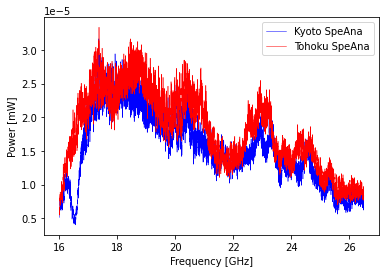

In [69]:
plt.plot(freq_1, power_1, label=f'{label_1}', color='blue', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
plt.plot(freq_2, power_2, label=f'{label_2}', color='red', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_power_mW.png')
plt.show()

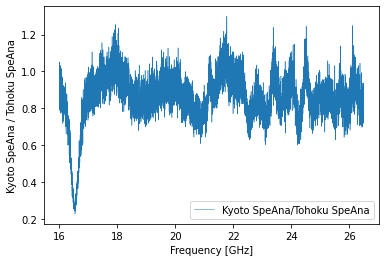

In [71]:
power_2_interp = freq_interpolate(freq_1, freq_2, power_2)
div_power = power_1/power_2_interp

plt.plot(freq_1, div_power, label=f'{label_1}/{label_2}', color='tab:blue', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'{label_1} / {label_2}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_power_div.png')
plt.show()

###  Plot Power [dBm]

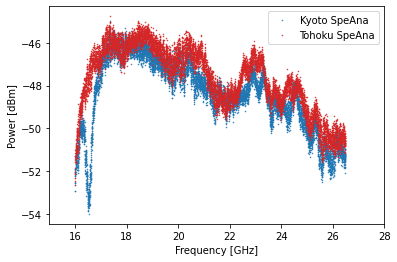

In [72]:
power_1_dBm = np.log10(power_1)*10.
power_2_dBm = np.log10(power_2)*10.

plt.plot(freq_1, power_1_dBm, label=f'{label_1}', color='tab:blue', marker='o', markersize=0.5, linestyle='')
plt.plot(freq_2, power_2_dBm, label=f'{label_2}', color='tab:red', marker='o', markersize=0.5, linestyle='')
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [dBm]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(-35,-20) #y軸範囲指定
plt.legend()

plt.savefig(f'{outdir}/compare_power_dBm.png')
plt.show()

### Plot averaged power

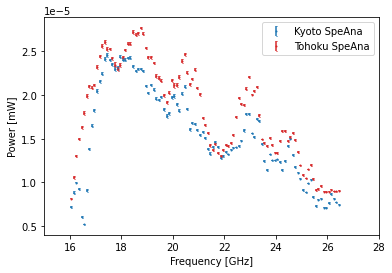

In [56]:
freq_ave_1, tmp = freq_average(freq_1, naverage=100)
freq_ave_2, tmp = freq_average(freq_2, naverage=100)
power_1_ave, power_1_ave_err = freq_average(power_1, naverage=100)
power_2_ave, power_2_ave_err = freq_average(power_2, naverage=100)
plt.errorbar(freq_ave_1, power_1_ave, yerr=power_1_ave_err, label=f'{label_1}', capsize=0.5, fmt='o', markersize=1, ecolor='tab:blue', markeredgecolor = "tab:blue", color='tab:blue')
plt.errorbar(freq_ave_2, power_2_ave, yerr=power_2_ave_err, label=f'{label_2}',  capsize=0.5, fmt='o', markersize=1, ecolor='tab:red', markeredgecolor = "tab:red", color='tab:red')

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
plt.legend()

plt.savefig(f"{outdir}/compare_power_average.png")
plt.show()

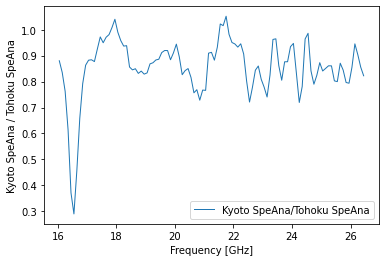

In [74]:
power_2_ave_interp = freq_interpolate(freq_ave_1, freq_ave_2, power_2_ave)
div_power_ave = power_1_ave/power_2_ave_interp

plt.plot(freq_ave_1, div_power_ave, label=f'{label_1}/{label_2}', color='tab:blue', marker='', markersize=0.5, linestyle='-', linewidth=1.0)
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'{label_1} / {label_2}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

plt.legend()

plt.savefig(f'{outdir}/compare_power-ave_div.png')
plt.show()